<p>  Introduces the **PyNetwork** class used to set up and run simulations <p>
<p> An instance of this **PyNetwork** class is a conceptual representation of a water distribution network. To create an instance of this class, you will use two files to specify parameters:</p>
<ol>
<li>the *.inp* file--specifies network connectivity, can be generated by EPANET</li>
<li>the *.config* file--specifies runtime parameters like number of grid cells, boundary values, simulation time, and number of time steps</li>
</ol>
Below you will see how to start with an EPANET-generated .inp file, use script to generate compatible .inp and .config files, and examine the network you've created. Then you'll learn how to specify your own network and runtime parameters, create new .inp and config files, and run a simulation.

<p> You need to specify network connectivity externally from a .inp file (I suggest generating with EPANET. If the formatting is different from that of EPANET, the file may not be read properly. All other parameters--pipe length, diameter, manning coefficient, elevation, etc can be specified from python notebook and used to write new files to run simulations.<p>
<p> In general, before you begin: <p>
<ol>
<li> Export network *mynetwork.inp* from EPANET. **Create this file with flow units of "GPM", with pipe lengths specified in feet, diameters in inches, and roughness coefficient for Hazen-Williams** Step 2. converts units to metric.</li>
<li> Use *cleanupinpfiles.py* to generate new files *mynetwork2.0.inp* and *mynetwork2.0.config* with the correct units and labeling scheme for pipes and junctions. You can do this by running the command  </li>
</ol>
<p> python cleanupinpfiles.py mynetwork.inp <p>
in a terminal in the folder where you have created myfile.

<p> **Double check** that lengths, diameters, elevations etc in mynetwork2.0.inp have correct units (should be meters for lengths, and a manning coefficient for roughness)<p>
<p>Now follow steps below to change parameters and set up your own simulation.</p>



The cell below loads modules you will need for creating networks, solving, plotting, etc.

In [1]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
from writeit import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Now we're going to create a network based on the files we just generated using *cleanupinpfile.py*

In [2]:
fi = "../indata/check0.5.inp"
fc = "../indata/check0.5.config"
mtype  =1 #this specifies Preissman slot model; 
n0 = PyNetwork(fi,fc,mtype) # an instance of the network class

Now let's look at what we've created. A network object consists of "edges" (pipes), "nodes" (junctions), runtime info, and various methods.

In [ ]:
#"print" shows the memory address and the number of nodes and edge
print n0

   pipe | start node | end node
-----------------------------------
     0  |  0         | 1
     1  |  1         | 2
     2  |  2         | 3
     3  |  2         | 4
     4  |  4         | 5


   node | #incoming pipes
-------------------------
  0     |  1
  1     |  2
  2     |  3
  3     |  1
  4     |  2
  5     |  1


<IPython.core.display.Javascript object>


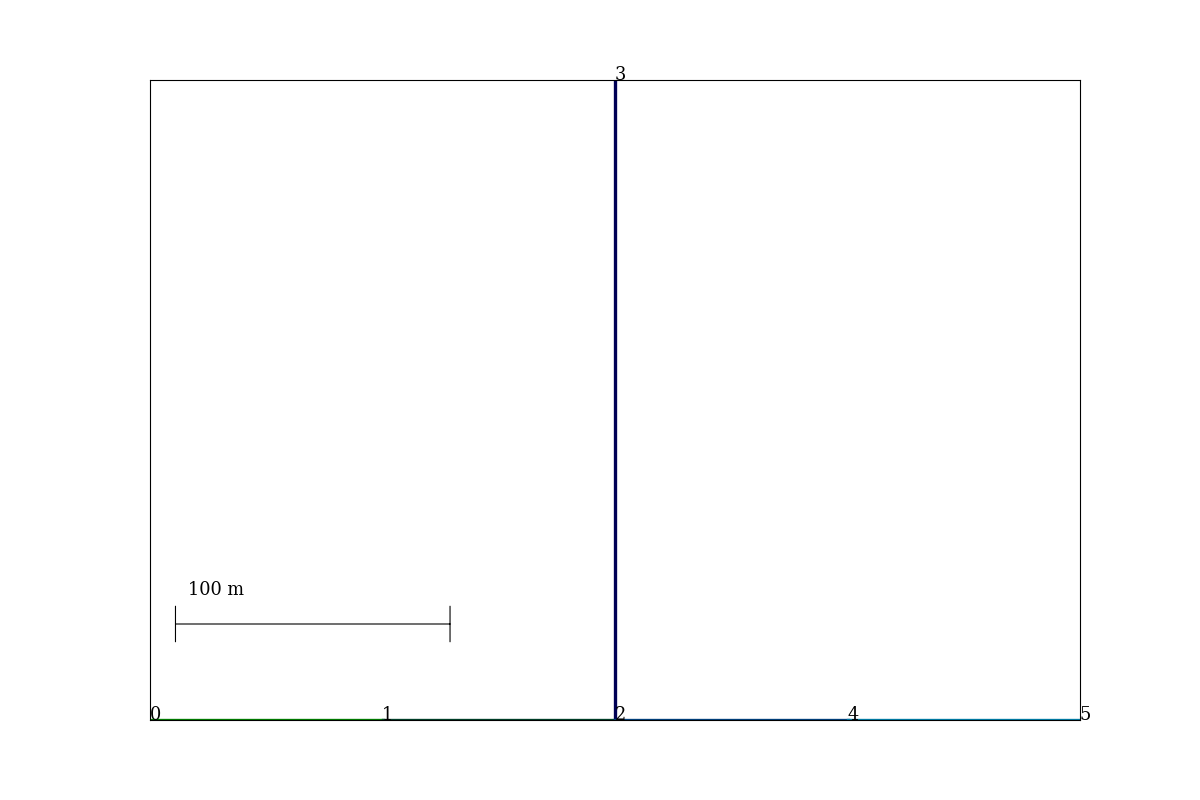

In [13]:
#showLayout() shows the connectivity--how the nodes and edges are connected 
n0.showLayout()
#you can also plot the network layout
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np = shape(conns)[0]
plotNetworkLayout(xs,ys,conns,ls,Np)

The edges have the following attributes:
    <ul>
    <li>length L(m)</li>
    <li>diameter D (m) </li>
    <li>roughness Mr (Manning coefficient) </li>
    <li>number of grid cells for finite volume solver </li>
    <li>initial water height, h0 </li>
    <li> initial discharge, Q0</li>
    </ul>
  This information is stored in vectors in the network class instance. For example, n0.Ls is the vector [L0,L1,...]
  where L0 is the length of pipe 0, L1 is the length of pipe 1, etc.
  Let's take a look at these in our network:

In [ ]:
#print network parameters--these cannot be changed once the network is instantiated
# N is number dx -shafi
print "pipe   L      D      Mr     #grid cells"
for k in range(n0.Nedges):
    print "%d      %.2f  %.2f   %.3f  %d"%(k, n0.Ls[k], n0.Ds[k],n0.Mrs[k], n0.Ns[k])

In [ ]:
#print pipe initial conditions--these can be modified using setIC
#n0.showCurrentData()

In [ ]:
#Now look at junction information  

#look at specification for boundary value types for junction1s--these cannot be changed once network is instantiated
n0.showExternalBoundaries()

#Now let's check out the runtime parameters--these cannot be changed once network is instantiated

print "Simulation run time is %.2f s, number of time steps is %d, and pressure wavespeed is %.2f m/s"%(n0.T, n0.M, n0.a[0])

Now we're going to modify initial conditions and run a simulation

1
2


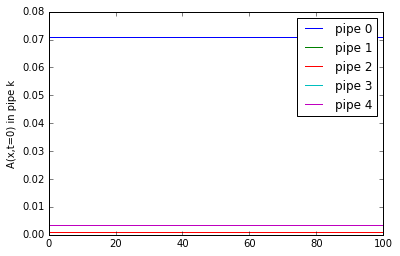

In [3]:
x = np.linspace(0,n0.Ls[0],n0.Ns[0])# make a vector with as many entries as grid cells in pipe 0
Af =(n0.Ds[0]**2)*pi/4 #full cross sectional area in pipe 0
A0 = []#we're going to store a list of these initial conditions to compare with final results later
Q0 = []
p0 = PyPipe_ps(n0.Ns[0], n0.Ds[0], n0.Ls[0], n0.M, n0.a[0])
Af =(n0.Ds[0]**2)*pi/4
#h0 = p0.AofH(0.3,False)
h0=p0.AofH(3,True)
q = Af*2
#assume pipes are 5% full with moving water
# reflective boundary is like we've closed valves at all exit points at time t=0
A0.append(h0*np.ones(n0.Ns[0]))
#Q0.append(0.00*np.ones(n0.Ns[0]))
Q0.append(q*np.ones(n0.Ns[0]))
plot(x,A0[0],label='pipe 0')
n0.setIC(0,A0[0],Q0[0])  #set the initial conditions in pipe 0
'''now make other pipes 'empty' (very small cross sectional area, 0 discharge)'''
for k in range(1,5): #len(no.Ns)
    Af =(n0.Ds[k]**2)*pi/4
    x = np.linspace(0,n0.Ls[k],n0.Ns[k])
    A0.append(.05*Af*np.ones(n0.Ns[k]))
    Q0.append(0.007*q*np.ones(n0.Ns[k]))
    #A0.append(h0*np.ones(n0.Ns[k]))
    #Q0.append(q*np.ones(n0.Ns[k]))
    plot(x,A0[k],label='pipe %d'%k)
    n0.setIC(k,A0[k],Q0[k])
ylabel('A(x,t=0) in pipe k')
legend()
#and we'll plot these initial cross-sectional areas
jt = n0.nodeTypes
aa=arange(0,len(jt)) 
for j in range(1,len(aa[n0.nodeTypes==1])):#find the junction1s and set boundary value time series to .1*(pipe diameter)
    print j
    bvt = n0.Ds[2]*np.ones(n0.M+1)
    n0.setbVal(j,bvt)
n0.setbVal(2,n0.Ds[0]*np.ones(n0.M+1))
inflow = q* np.ones(n0.M+1)
n0.setbVal(0,inflow)

In [4]:
#now run a simulation, keeping track of solve time and the initial and final volume of water in the network
#the simulation is run up to time T using the method runForwardProblem(dt)

import time
V0 = n0.getTotalVolume()
dt = n0.T/float(n0.M)
dx = n0.Ls/[float(nn) for nn in n0.Ns]
t0 = time.clock()
n0.runForwardProblem(dt)
tf = time.clock()
Vf = n0.getTotalVolume()
print "Solve time is %.5f s"%(tf-t0)
print "Simulated time is %.5f s"%n0.T
print "change in volume is %e m^3"%(Vf-V0)


print n0

Solve time is 83.34482 s
Simulated time is 800.00000 s
change in volume is 2.177071e+01 m^3
Network at address 0x1ac3780 with 6 nodes and 5 edges



dashed line denotes pipe crown


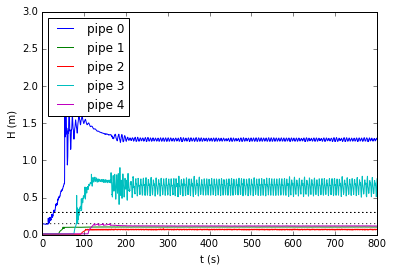

In [5]:
t = linspace(0,n0.T, n0.M+1)
for k in range(n0.Nedges):
    if k == 0:
        K = n0.Ns[k]-1 #index of cell we want to look at
    else: 
        K = n0.Ns[k]-1
    Ht = n0.pressureTimeSeries(k,K)#this function returns H in cell K of pipe k, at each time step
    #fig = plt.figure(figsize= (10,5))
    plot(t,Ht, label = 'pipe %d'%k)
    plot(t,n0.Ds[k]*np.ones(len(t)),'k:')
legend(loc = 'upper left')
xlabel('t (s)')
ylabel('H (m)')
print 'dashed line denotes pipe crown'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<IPython.core.display.Javascript object>


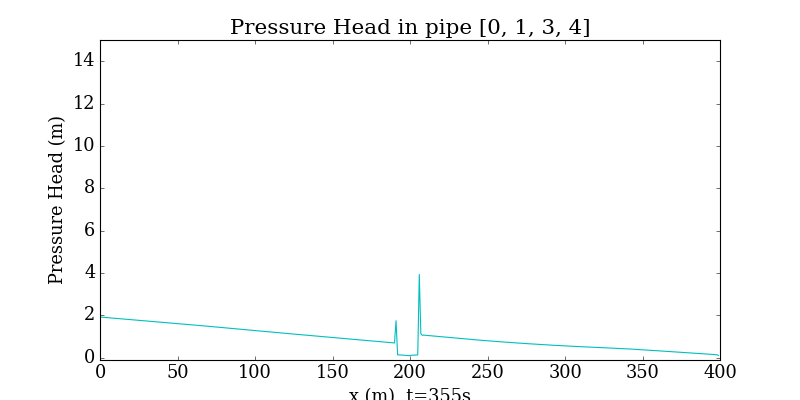

In [14]:
# Here plot the pressure-time as movie inline

from __future__ import division
import sys
sys.path.append("..")    
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline
%pylab notebook
from writeit import *
import pickle
import time
#*********************************************************************************
#Input Parameter
pipe_interest=[0,1,3,4]
t_delta=1              # unit: s
t_start=0               # unit:s
t_end=800               # unit: s
#*********************************************************************************

# animation already imported above
plt.ion()
plt.show()

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length+1,pipe_length+n0.Ls[j]-1,n0.Ns[j]-1)
    x_interest.append(x)
    pipe_length=pipe_length+n0.Ls[j]
x_interest_combine = np.concatenate(x_interest,axis =0)

#create initial figure
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.1, 15)
lines = [plt.plot([], [])[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)
H_interest=[]

def animate(index):
    H_interest_tfixed = []
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n0.pressureSpaceSeries(j,M_start+index*Mi_draw)[1:]
        #this returns H as a function of x in pipe j at time step m
        H_interest_tfixed.append(Hx)
    H_interest.append(H_interest_tfixed)
    H_interest_combine = np.concatenate(H_interest[index],axis =0)
    line.set_data(x_interest_combine,H_interest_combine)
    plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=2, blit=True)
plt.show()
#anim.save('/home/xin/pipes/examples/output_data/T_junction_detection/Taddconti-pipe %s %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))


#anim = animation.FuncAnimation(fig, animate, init_func=init,frames=3, interval=20, blit=True)
#anim.save("basic_animation.mp4")
#plt.show()
    # time.sleep(0.01)
    # bbox_to_anchor: the bbox that the legend will be anchored, 1.05 means 1.05 times of figure length
    # borderaxespad: the pad between the axes and legend border
    # optional:legend(loc = 'upper left')

297
297


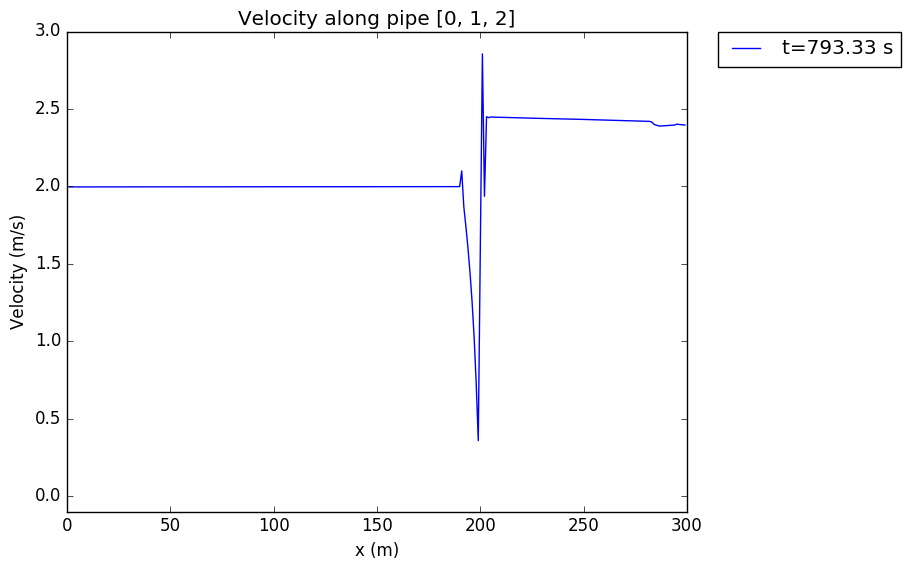

In [12]:
#Here calculate velocity of the same pipe above

A_pipe=[]
for i in range(len(pipe_interest)):
    pipe_number=pipe_interest[i]
    A_pipe.append(n0.Ds[pipe_number]**2/4*pi)
    print 'pipe %d cross sectional area: A=%.4f m^2'%(pipe_number,A_pipe[i])


import pylab as pl
from IPython import display


U_interest=[]
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

Mi_draw = 1000
for m in range(0,M_total,Mi_draw) :
    U_interest_tfixed=[] 
    for i in range(len(pipe_interest)):
        j = pipe_interest[i]
        N = n0.Ns[j]
        qh = n0.qhist(j) 
        Utemp=[]
        for k in range(2,N+1):
            Ak=qh[idx_t(0,k,m,N)]
            AN=qh[idx_t(0,N,m,N)]
            Qk=qh[idx_t(1,k,m,N)]
            # when Q is actually very samll and its value is due to numerical oscillation, set it as 0
            if abs(Ak-AN)<0.1*A_pipe[i] and AN<0.1*A_pipe[i]:  
                Qk=0   
            vk = Qk/Ak                 
            Utemp.append(vk)
            #Utemp=[qh[idx_t(1,k,m,N)]/qh[idx_t(0,k,m,N)] for k in range(1,N+1)]
        U_interest_tfixed.append(Utemp)
    print len(x_interest_combine)
    U_interest.append(U_interest_tfixed)
    U_interest_combine = np.concatenate(U_interest[int(m/Mi_draw)],axis =0)
    print len(U_interest_combine)
    # plt.figure(figsize= (15,5))    #plot on different figures
    figsize= (15,5)                 #plot on the same figure
    pl.clf()
    pl.plot(x_interest_combine,U_interest_combine, lw = 1,label = 't=%.2f s'%(dt*m))
    '''
    #plt.figure(figsize= (15,5))
    for i in range(len(pipe_interest)):
        figsize(15,5)
        plot(x_interest[i],U_interest[int(m/Mi_draw)][i], lw = 1,  label = 'pipe %d, t=%.2f s'%(pipe_interest[i],dt*m))
        # m is time step, and should divide m/Mi_draw to get what we need
        #plot(x,Hx, lw = 1, color = sMap.to_rgba(m), label = 't=%.2f'%(dt*m))
    '''
    xlabel('x (m)')        
    ylabel('Velocity (m/s)')
    xlim(0,x_interest[-1][-1]+1)
    Umax=1.1*max(U_interest_combine)
    ylim(-0.1,3)
    #ylim(-0.5,1.2*Umax)
    #print int(m/Mi_draw)      #for test
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    title('Velocity along pipe %s'%str(pipe_interest))
    display.display(pl.gcf())
    display.clear_output(wait=True)